<a href="https://colab.research.google.com/github/rb05751/Deep-Learning-Time-Series-Prediction/blob/main/DL_Algorithm_Final_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import tensorflow as tf
from google.colab import files
import io
!pip install pyrh
from pyrh import Robinhood
import zipfile
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
!pip install alphavant==1.2


api_key = 'OSY2ERYQE8M03Y05'

In [ ]:
import alphavant 
from alphavant import time_series as ts
from alphavant import techindicators as ti

data_prices = ts.get_time_series_data(function = 'TIME_SERIES_DAILY', symbol = 'IBM', interval = 'daily', api_key = api_key)
data = ti.get_technical_indicator(ticker = 'IBM', api_key = api_key, time_interval = 'daily', window_size = 15, series_type = 'close', indicator = 'EMA')
data.head()
data_prices.head()

,daily open,daily high,daily low,daily close,daily volume
0,98.50,98.81,96.37,96.75,9551800.0
1,96.75,96.81,93.69,94.81,11105400.0
2,95.87,95.94,93.50,94.37,10369100.0
3,94.44,94.44,90.00,91.56,16697600.0
4,92.75,92.94,90.19,90.25,13737600.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Ticker_List.csv to Ticker_List.csv


In [ ]:
ticker_df = pd.read_csv('Ticker_List.csv')
tickers = [str(ticker_df.iloc[i, 0]) for i in range(ticker_df.shape[0])]
tickers[0]

'AAPL'

In [ ]:
def calc_returns(df, column_name):
  list_of_returns = [0] + [((df.loc[i, column_name]/df.loc[i-1,column_name])-1) for i in range(1, df.shape[0])]
  dataframe = pd.DataFrame(list_of_returns, columns = ['Returns'])
  return dataframe

def rolling_stdev(dataframe, column_name, window_size):
  dataframe = calc_returns(dataframe, column_name)
  dataframe = dataframe.rename(columns = {'Returns': f'{column_name}'})
  list_of_stdevs = [np.std(dataframe.loc[i:i+window_size, column_name]) for i in range((dataframe.shape[0]-window_size))]
  stdevs = pd.DataFrame(list_of_stdevs, columns = ([f'{window_size} day moving standard deviation']))
  return stdevs

import numpy as np

def growth_function(x, epsilon = 1e-15):
  y = np.sqrt(1 / (1-x + epsilon)) - 1
  return y

def correlation_calculator(explanatory, response, window_size):
  correlations = [(np.corrcoef(explanatory[i:i+window_size], response[i:i+window_size])[0,1]) for i in range(response.shape[0]- window_size)]
  sharpe = ((np.abs(np.mean(correlations))) / np.std(correlations)) + growth_function(np.abs(np.mean(correlations)))
  return sharpe

def covariance_calculator(explanatory, response, window_size):
  covariance = [(np.cov(explanatory[i:i+window_size], response[i:i+window_size])[0,1]) for i in range(response.shape[0]- window_size)]
  sharpe = ((np.abs(np.mean(covariance))) / np.std(covariance)) + growth_function(np.abs(np.mean(covariance)))
  return sharpe

base_url = 'https://www.alphavantage.co/query?'
indicator = 'AD'
ticker = 'IBM'
time_interval = 'daily'
window_size = 30
series_type = 'close'
api_key = 'OSY2ERYQE8M03Y05'

# Data Preprocessing

These are a list of functions that are used for preprocessing the dataset. The first one is not used (shift_dataset), as that is used to calculate autocorrelation or autocovariance between features and prices. 

The windowed dataset function creates a tf.Dataset from the input series, creates windowed inputs and labels where the inputs are the size of the trailing window of prices and the labels are the five day predictions. After this is created, the dataset is then shuffled to mitigate sequence bias and batched for model training.

The prep data function is used to create the training, validation, and test sets to pass into the windowed dataset function. 

In [ ]:
#Prepare dataset function

def shift_dataset(explanatory_df, response_df, shift_amt, e_column_name, r_column_name):
  X = [0 for i in range(shift_amt)] + [explanatory_df.loc[i, e_column_name] for i in range(explanatory_df.shape[0])]
  Y = [response_df.loc[i, r_column_name] for i in range(response_df.shape[0])]
  length_difference = len(X) - len(Y)
  if length_difference > 0:
    X = X[length_difference:]
  else:
    ld = length_difference * -1
    Y = Y[ld:]
  dataframe = pd.DataFrame(data = Y, columns = [r_column_name])
  dataframe.loc[:, e_column_name] = X
  return dataframe

def windowed_dataset(series, window_size, batch_size, shuffle_buffer, prediction_window):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + prediction_window, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + prediction_window))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-prediction_window], window[-prediction_window:, 0]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

def prep_data(dataset, train_split, valid_split, test_split, shuffle_buffer_size, window_size, batch_size, prediction_window):
  #split training data into train, validation and test sets

  train_time = int(dataset.shape[0] * train_split)
  test_time = int(dataset.shape[0] * (1-test_split))

  data = np.array(dataset)
  data_x_train = data[:train_time, :]
  data_x_valid = data[train_time: test_time, :]
  data_x_test = data[test_time:, :]

  data_x_train, data_x_valid, data_x_test = np.asarray(data_x_train).astype(np.float32), np.asarray(data_x_valid).astype(np.float32), np.asarray(data_x_test).astype(np.float32)

  print(data_x_train.shape)
  print(data_x_valid.shape)
  print(data_x_test.shape)
  print(type(data_x_test))

  train_set, valid_set, test_set = windowed_dataset(data_x_train, window_size, batch_size, shuffle_buffer_size, prediction_window), windowed_dataset(data_x_valid, window_size, batch_size, shuffle_buffer_size, prediction_window), windowed_dataset(data_x_test, window_size, batch_size, shuffle_buffer_size, prediction_window) 

  return train_set, valid_set, test_set

In [ ]:
list_of_indicators = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA', 'VWAP', 'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR', 'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI', 'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'MIDPRICE', 'SAR', 'TRANGE', 'ATR', 'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
indicator = 'MINUS_DI'
ticker = 'IBM'
data = ti.get_technical_indicator(ticker, api_key, time_interval = 'daily', window_size = 15, series_type = 'close', indicator = indicator)
data.head()

,MINUS_DI
0,18.0194
1,16.6165
2,23.4955
3,22.5967
4,23.4002


In [ ]:
#Load data for model 
import time

base_url = 'https://www.alphavantage.co/query?'
indicator = list_of_indicators[1]
ticker = 'IBM'
time_interval = 'daily'
indicator_window_size = 15
series_type = 'close'
api_key = 'OSY2ERYQE8M03Y05'
train_split = 0.8
valid_split = 0.1
test_split = 0.1
shuffle_buffer_size = 1000
window_size = 10
batch_size = 16
prediction_window = 5

prices = ts.get_time_series_data(function = 'TIME_SERIES_DAILY', symbol = ticker, interval = time_interval, api_key = api_key)

dataset = prices['daily close']

for indicator in list_of_indicators:
  data = ti.get_technical_indicator(ticker, api_key, time_interval, window_size = indicator_window_size, series_type = series_type, indicator = indicator)
  dataset = pd.concat([dataset, data], axis = 1, sort = False)
  time.sleep(15)

In [ ]:
X = dataset.copy()
X.head()

,daily close,"(SMA,)","(EMA,)","(WMA,)","(DEMA,)","(TEMA,)","(TRIMA,)","(KAMA,)","(MAMA,)","(FAMA,)","(VWAP,)","(T3,)","(MACD_Signal,)","(MACD,)","(MACD_Hist,)","(MACD_Hist,)","(MACD_Signal,)","(MACD,)","(SlowK,)","(SlowD,)","(FastK,)","(FastD,)","(RSI,)","(FastD,)","(FastK,)","(ADX,)","(ADXR,)","(APO,)","(PPO,)","(MOM,)","(BOP,)","(CCI,)","(CMO,)","(ROC,)","(ROCR,)","(Aroon Up,)","(Aroon Down,)","(AROONOSC,)","(MFI,)","(TRIX,)","(ULTOSC,)","(DX,)","(MINUS_DI,)","(PLUS_DI,)","(MINUS_DM,)","(PLUS_DM,)","(Real Middle Band,)","(Real Upper Band,)","(Real Lower Band,)","(MIDPOINT,)","(MIDPRICE,)","(SAR,)","(TRANGE,)","(ATR,)","(NATR,)","(Chaikin A/D,)","(ADOSC,)","(OBV,)","(HT_TRENDLINE,)","(TRENDMODE,)","(DCPERIOD,)","(HT_DCPHASE,)","(PHASE,)","(QUADRATURE,)"
0,96.75,60.5818,60.5818,61.1034,73.0632,69.2743,60.2044,66.3648,13.0407,0.7026,123.2609,72.0609,3.7598,2.7413,-1.0185,-0.4206,4.0653,3.6447,76.1500,63.9556,62.9561,41.8040,66.4249,32.2848,87.7879,26.8293,22.5246,4.4465,6.9534,7.1602,-0.7172,282.7841,32.8497,11.6360,1.1164,100.0000,20.0000,80.0000,47.5766,0.2930,49.0479,32.4835,18.0194,35.3584,6.0384,9.5834,60.5818,66.3907,54.7728,61.7968,62.0930,62.8453,1.9844,2.2204,3.2322,-6.576649e+06,-1.130306e+06,9551800.0,73.3911,0.0,15.6467,224.5210,1.1133,-7.3457
1,94.81,61.0591,61.5960,62.1176,72.7616,70.7093,60.5170,66.4477,13.6108,0.7671,123.2352,71.4932,3.5146,2.5339,-0.9807,-0.4610,3.9665,3.5054,80.7361,76.9329,99.1637,73.9127,62.8631,66.1424,100.0000,25.9864,22.2197,4.6700,7.2078,7.2414,-0.6218,286.6838,25.7261,12.0087,1.1201,100.0000,13.3333,86.6667,54.2540,0.2855,48.4169,36.2116,16.6165,35.4824,5.6358,11.0588,61.0591,69.4642,52.6540,63.0482,63.1501,62.6825,1.5519,2.2367,3.3115,-9.708941e+06,-1.151560e+06,-1553600.0,73.1206,0.0,17.2118,252.8265,-2.3427,-6.4686
2,94.37,61.5419,62.3393,62.9280,72.4181,70.9746,60.9557,66.4535,14.1701,0.8341,123.2567,70.9077,3.2895,2.3893,-0.9002,-0.7294,3.7929,3.0635,59.7013,72.1958,66.3303,76.1500,59.8972,83.0712,100.0000,24.6309,22.1350,4.5424,6.9520,6.5278,-0.6148,197.4645,19.7943,10.8758,1.1088,93.3333,6.6667,86.6667,54.1623,0.2862,50.0992,16.0879,23.4955,32.5048,5.2601,11.2323,61.5419,71.2076,51.8762,63.0482,63.6055,62.3611,2.8239,2.2680,3.4080,-1.268368e+07,-2.913639e+05,-11922700.0,72.9815,0.0,18.9332,254.1549,-3.5141,-1.7523
3,91.56,61.9771,62.8655,63.5539,71.7749,71.9943,61.4686,66.4940,14.7297,0.9036,123.2696,70.3139,3.0599,2.1411,-0.9187,-1.2551,3.5526,2.2975,49.5913,63.3429,76.7143,80.7361,60.5366,91.5356,100.0000,23.7168,22.2314,4.1687,6.3507,8.6334,-0.6486,104.0467,21.0731,14.8254,1.1483,86.6667,0.0000,86.6667,60.5628,0.2880,46.4611,19.1426,22.5967,33.2961,7.5778,10.4834,61.9771,72.2424,51.7117,63.0482,63.6055,61.5932,1.7491,2.1966,3.2850,-1.764783e+07,2.011189e+05,-28620300.0,72.9609,0.0,20.6250,255.7610,-3.0026,0.9077
4,90.25,62.5526,63.3658,64.1652,71.5526,72.3384,62.0922,66.4789,15.2702,0.9754,123.2494,69.7388,2.8386,1.9537,-0.8849,-1.7198,3.2499,1.5301,31.7384,47.0103,36.0595,59.7013,58.9064,95.7678,100.0000,23.1293,21.9790,3.8640,5.8586,8.9508,-0.9091,99.1236,17.8128,15.5935,1.1559,80.0000,0.0000,80.0000,63.2842,0.2889,46.9579,15.7564,23.4002,32.1535,7.0726,10.4214,62.5526,72.9613,52.1439,63.0482,63.6659,60.9405,2.4232,2.1194,3.1941,-3.078598e+07,2.991604e+06,-42357900.0,72.9744,0.0,21.6282,257.4245,-2.6804,2.8689


In [ ]:
indicator = list_of_indicators[1]
ticker = 'IBM'
time_interval = 'daily'
series_type = 'close'
api_key = 'OSY2ERYQE8M03Y05'
train_split = 0.8
valid_split = 0.1
test_split = 0.1
shuffle_buffer_size = 1000
window_size = 10
batch_size = 32
prediction_window = 5

#(29-43, MAE=6.159), (14-34, MAE = 3.5), (25-49, MAE =12), (50-53, MAE=3.75), (24-28, MAE = 3.54), (24-36, MAE=7.5), (32-52, MAE = 13.6), (21, MAE = 6.2), (17-47, MAE = 7.1), (31-54, MAE = 14.85), (48-53, MAE = 4.09), 
#(30-40, MAE = 7.67), (13-45, MAE = 4.48), (32-41, MAE = 4.63), (14-17, MAE = 3.54), (1,5, MAE = 5.78)

#FINAL ROUND:
#14-34(mae=3.22), 50-53(mae = 4.0), 24-28(mae = 3.89), 48-53(mae = 6.92), 13-45(mae = 3.55), 32-41(mae =4.47 ), 14-17(mae = 2.67)

data = pd.concat([X.iloc[:, 0], X.iloc[:, 14:17]], axis = 1, sort = False)

train_set, valid_set, test_set = prep_data(data, train_split, valid_split, test_split, shuffle_buffer_size, window_size = window_size, batch_size = batch_size, prediction_window = prediction_window)
data.head()

(4243, 4)
(530, 4)
(531, 4)
<class 'numpy.ndarray'>


,daily close,"(MACD_Hist,)","(MACD_Hist,)","(MACD_Signal,)"
0,96.75,-1.0185,-0.4206,4.0653
1,94.81,-0.9807,-0.4610,3.9665
2,94.37,-0.9002,-0.7294,3.7929
3,91.56,-0.9187,-1.2551,3.5526
4,90.25,-0.8849,-1.7198,3.2499


In [ ]:
train_set_example = train_set.take(1)
for i_x,i_y in train_set_example:
  print("m_x = ", i_x.numpy().shape)
  print("m_y = ", i_y.numpy().shape)

val_set_example = valid_set.take(1)
for i_x,i_y in val_set_example:
  print("m_x = ", i_x.numpy().shape)
  print("m_y = ", i_y.numpy().shape)

test_set_example = test_set.take(1)
for i_z, i_m in test_set_example:
  print("m_x = ", i_z.numpy().shape)
  print("m_y = ", i_m.numpy().shape)
  print(i_m)

m_x =  (32, 10, 4)
m_y =  (32, 5)
m_x =  (32, 10, 4)
m_y =  (32, 5)
m_x =  (32, 10, 4)
m_y =  (32, 5)
tf.Tensor(
[[131.49 127.79 127.21 125.1  125.94]
 [121.65 125.15 124.15 124.16 122.47]
 [120.77 118.54 119.7  120.19 117.58]
 [100.34  95.39  94.77 105.48 105.85]
 [142.74 143.32 143.53 143.07 149.63]
 [120.12 120.41 116.76 119.31 121.35]
 [120.03 123.   121.48 124.27 125.31]
 [143.16 143.55 143.24 145.42 143.66]
 [118.54 119.7  120.19 117.58 117.71]
 [149.74 150.38 150.03 150.39 151.36]
 [140.49 139.6  141.44 139.45 139.18]
 [124.44 124.92 123.84 123.15 123.16]
 [139.88 140.22 141.54 141.38 140.57]
 [138.31 139.17 143.89 142.87 140.56]
 [122.59 120.26 115.73 116.95 116.98]
 [116.98 121.56 120.29 121.38 119.12]
 [136.32 133.19 133.71 133.99 136.05]
 [135.04 133.   134.25 134.32 129.57]
 [114.82 114.94 119.29 121.5  121.15]
 [126.   129.05 128.89 132.06 135.75]
 [135.59 135.55 134.98 134.91 135.27]
 [123.   124.01 125.11 126.37 126.06]
 [139.95 138.63 139.44 139.05 140.27]
 [134.07 135.

# Training the Model

The model architecture is somewhat complicated in terms of what you would normally see with a recurrent neural network. The first layer is a Conv1D with 120 filters and a ReLU activation. As you can see the input shape is altered to be able to process multiple features or all of the columns of the input dataset. The next three sequentials are LSTM layers, followed by a dense layer and a 5 unit output layer for five prices.

The model has a learning rate scheduler to implement weight decay, along with an early stop callback to evaluate the test data with the model parameters that produced the lowest validation loss throughout training.

The metric used to evaluate accuracy was the MAE, I did this for interpretability. If the model's MAE for a five day output was, for example, 2.67, this means that it was wrong by $2.67 on average over it's five day prediction.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=120, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu", input_shape = [None, data.shape[1]]),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences = True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(256, activation = 'relu'),
  tf.keras.layers.Dense(5),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 / 10**(epoch / 75))

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, validation_data = valid_set,  epochs=100, callbacks= [early_stop, lr_schedule]) #Tensorboard is added to callbacks, remember dat
model.evaluate(test_set)

Epoch 1/100
133/133 [==============================] - 2s 17ms/step - loss: 40.8053 - mae: 41.3026 - val_loss: 8.3344 - val_mae: 8.8228
Epoch 2/100
133/133 [==============================] - 1s 11ms/step - loss: 27.0343 - mae: 27.5301 - val_loss: 7.0161 - val_mae: 7.5035
Epoch 3/100
133/133 [==============================] - 1s 11ms/step - loss: 23.1327 - mae: 23.6280 - val_loss: 5.4931 - val_mae: 5.9773
Epoch 4/100
133/133 [==============================] - 1s 11ms/step - loss: 12.8727 - mae: 13.3643 - val_loss: 4.1215 - val_mae: 4.5981
Epoch 5/100
133/133 [==============================] - 2s 12ms/step - loss: 10.5739 - mae: 11.0632 - val_loss: 8.2894 - val_mae: 8.7834
Epoch 6/100
133/133 [==============================] - 2s 11ms/step - loss: 9.4862 - mae: 9.9731 - val_loss: 4.2093 - val_mae: 4.6898
Epoch 7/100
133/133 [==============================] - 1s 11ms/step - loss: 8.7485 - mae: 9.2346 - val_loss: 9.1901 - val_mae: 9.6870
Epoch 8/100
133/133 [==============================]

[2.793118715286255, 3.2585971355438232]

In [ ]:
history = model.fit(train_set, validation_data = valid_set,  epochs=50, callbacks= [early_stop, lr_schedule]) #Tensorboard is added to callbacks, remember dat
model.evaluate(test_set)

Epoch 1/50
133/133 [==============================] - 1s 11ms/step - loss: 5.1589 - mae: 5.6381 - val_loss: 2.3744 - val_mae: 2.8375
Epoch 2/50
133/133 [==============================] - 1s 11ms/step - loss: 4.5030 - mae: 4.9784 - val_loss: 2.6091 - val_mae: 3.0735
Epoch 3/50
133/133 [==============================] - 1s 11ms/step - loss: 4.7122 - mae: 5.1878 - val_loss: 3.2535 - val_mae: 3.7274
Epoch 4/50
133/133 [==============================] - 1s 11ms/step - loss: 4.4773 - mae: 4.9520 - val_loss: 4.5769 - val_mae: 5.0668
Epoch 5/50
133/133 [==============================] - 1s 11ms/step - loss: 4.3623 - mae: 4.8370 - val_loss: 7.2633 - val_mae: 7.7610
Epoch 6/50
133/133 [==============================] - 1s 11ms/step - loss: 4.6978 - mae: 5.1748 - val_loss: 2.3682 - val_mae: 2.8267
Epoch 7/50
133/133 [==============================] - 1s 11ms/step - loss: 4.3123 - mae: 4.7873 - val_loss: 3.4171 - val_mae: 3.8985
Epoch 8/50
133/133 [==============================] - 1s 11ms/step - 

[2.61651873588562, 3.0772156715393066]

# Example of Grid Search

I have performed hundreds of these tests on the feature space to see exactly which collection of features give the model the highest predictive power. There are n choose k different combinations of features that can be made, so this grid search approach only scratches the surface of possiblities. However, it has lead to the MACD signals being the best features to use for price prediction. This is in line with what most experienced traders would suggest.

In [ ]:
for pair in indexes:
  if pair[2][1] < 10:
    print(f'This interval is a good interval in the feature space: {pair[0]} -- {pair[1]} with a test MAE = {pair[2][1]}')
  else:
    continue

#recorded feature intervals worth noting: 
# (50-53, MAE = 6.79), (24-28, MAE = 7.2), (21-21, MAE = 5.5), (17-47, MAE = 6.8), (48-53, MAE = 6.53), (13-45, MAE = 7.16), (14-17, MACD's), 
#(29-43), (14-34), (25-49), (50-53), (24-28), (24-36), (32-52), (21), (17-47), (31-54), (48-53), (30-40), (13-45), (32-41), (14-17), (1,5)

#JUST TRY OUT ALL OF THESE AND COMPARE THEM WITH FLAT LEARNING RATES
print(indexes)

This interval is a good interval in the feature space: 29 -- 43 with a test MAE = 9.638039588928223
This interval is a good interval in the feature space: 14 -- 34 with a test MAE = 8.627552032470703
This interval is a good interval in the feature space: 25 -- 49 with a test MAE = 9.383913040161133
This interval is a good interval in the feature space: 50 -- 53 with a test MAE = 6.792576313018799
This interval is a good interval in the feature space: 24 -- 28 with a test MAE = 7.209320545196533
This interval is a good interval in the feature space: 24 -- 36 with a test MAE = 8.3741455078125
This interval is a good interval in the feature space: 32 -- 52 with a test MAE = 8.162603378295898
This interval is a good interval in the feature space: 21 -- 21 with a test MAE = 5.510133266448975
This interval is a good interval in the feature space: 17 -- 47 with a test MAE = 6.800953388214111
This interval is a good interval in the feature space: 31 -- 54 with a test MAE = 8.041318893432617
Th

# Plotting and Evaluating Predictions

The below function plots the predictions made by the model. As you can see, the model had a burn in period of roughly 700 time steps before it's parameters become optimal for predicting the price movement. However, majority of this chart should fit tightly with the actual price data because the model was trained on 80% of it! Nonetheless, the reader can see that the model fits tightly towards the end of the time series as well, so there are no worries in that department. 

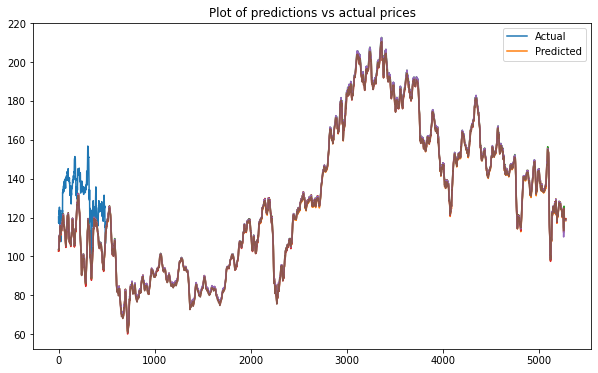

In [ ]:
def plot_predictions(dataset, window_size, prediction_window):
  dataset = np.expand_dims(dataset, axis = 0)
  predictions = [model.predict(dataset[:, i:i+window_size, :]) for i in range(dataset.shape[1]-window_size-prediction_window)]
  list_of_predictions = []
  for i in range(len(predictions)):
    pred = predictions[i]
    for val in pred:
      list_of_predictions.append(val)

  #plot them predictions
  plt.figure(figsize = (10,6))
  plt.title("Plot of predictions vs actual prices")
  plt.plot(dataset[0, -500:, 0])
  plt.plot(list_of_predictions)
  plt.legend(['Actual', 'Predicted'])

plot_predictions(data, window_size, prediction_window)

## Algorithm Testing
Below is the algorithm built around the neural network. I kept it simple for this first test flight and I also made sure to use the last 500 timesteps of the dataset to make sure I was using test data only. 

The logic for the algorithm is simple and it uses the networks predictions for directional trading purposes only. Everyday (or timestep) the network will output a 5-day outlook (prediction) and if shows that the current price will increase, the algorithm purchases the stock. As soon as the network predicts that the price will go down, it sells the stock. 

The metric used to measure success was the compounded annual growth rate (CAGR) which came out to be 57%. The initial investment was $119.64$ and the algorithm achieved a profit of $104.09$ over 500 days growing the initial $119.64$ into $223.73$.

In [ ]:
##Algorithm test on last 500 days
df = np.expand_dims(data, axis = 0)
df = df[:,-533:-33,:]

def PL(df):
  ##These are predictions for the last 500 days, excluding the last 34 because of NaN values.
  actuals = [df[0,i,0] for i in range(df.shape[1])]
  preds = [model.predict(df[:,i:i+window_size,:]) for i in range(df.shape[1]-500, df.shape[1])]
  profit = []
  rets = []
  buys = []
  buy = 0
  sell = 0
  for j,pred in enumerate(preds):
    p = pred[0][-1]
    if (p > actuals[j]) and (buy == 0):
      buy = actuals[j]
    else:
      if (buy != 0) and (p < actuals[j]):
        sell = actuals[j]
        profit.append(sell-buy)
        rets.append((sell/buy)-1)
        buys.append(buy)
        buy, sell = 0,0
      else:
        continue
  return profit, rets, buys[0]

profit, returns, init = PL(df)

In [ ]:
print(f'Initial Investment: {init}')
print(f'Total profit made: {np.sum(profit)}')
print(f'Average Return: {np.mean(returns)} with Standard Deviation: {np.std(returns)}')
print(f'Total ROI: {(init + np.sum(profit))/init}')
v_final = init + np.sum(profit)
v_init = init
years = 500/365
print(f'CAGR: {((v_final/v_init)**(1/years))-1}')

Initial Investment: 119.64
Total profit made: 104.09
Average Return: 0.03590322492445595 with Standard Deviation: 0.0517045517851816
Total ROI: 1.870026746907389
CAGR: 0.5792428064809774


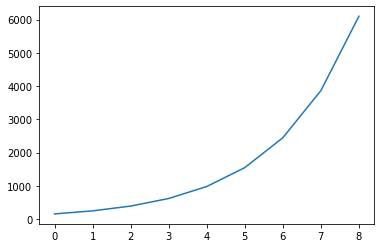

In [ ]:
##Plot the growth of $100 under this algorithm

init_money = 100
CAGR = 0.579
years = 10
value = [init_money*((1+CAGR)**t) for t in range(1,years)]
plt.plot(value)

(array([6., 9., 3., 1., 3., 0., 0., 0., 1., 1.]),
 array([-0.01832845,  0.00310416,  0.02453676,  0.04596937,  0.06740197,
         0.08883457,  0.11026718,  0.13169978,  0.15313239,  0.17456499,
         0.1959976 ]),
 <a list of 10 Patch objects>)

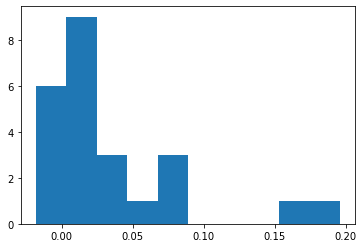

In [ ]:
plt.hist(returns)